# CAPSTONE 3. Predicting Major Cryptocurrencies Prices
## Modeling

In this notebook we will continue to implement different times series forecasting algorithms in order to predict Bitcoin price. In particular, we will build three models:
<ul>
    <i>Exponential Smoothing</i> - a time series forecasting method for univariate data, which can be used as an alternative for ARIMA family of methods<br>
    <i>Prophet</i> - a time-series forecasting model developped by Facebook<br>
    <i>PyCaret</i> - a Python version of the Caret machine learning package in R<br>
</ul>
As always, we will train the models on the training set and evaluate them on the test set. The train and test sets will be the same that we used in the previous notebook.<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
import warnings
import os
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from fbprophet import Prophet
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

#setting figure's default size
sns.set(rc={'figure.figsize':(12,5)})
plt.rcParams['figure.figsize'] = (12,5)

sns.set_style('whitegrid')

pd.options.display.float_format = "{:.3f}".format

First, let's import the data we saved in the previous step. We will use it for our analysis.

In [2]:
df = pd.read_pickle('../PTDD/df.pkl')
train = np.load('../PTDD/train_norm.npy')
test = np.load('../PTDD/test_norm.npy')
btc = pd.read_pickle('../EDA/btc.pkl')
# btc_price = btc[['Date', 'Close']].sort_values(by='Date', ascending=True)
btc_price = btc['Close'].sort_values(ascending=True)

In [3]:
btc_price = btc['Close'].values

In [4]:
print(f'Train set observations: {len(train)}')
print(f'Test set observations: {len(test)}')

Train set observations: 1964
Test set observations: 30


And take a look once again at BTC price time series.

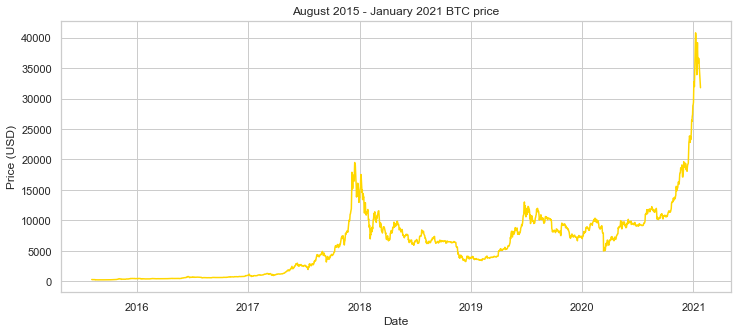

In [5]:
sns.lineplot(data=btc, x='Date', y='Close', color='Gold')
plt.title(f'August 2015 - January 2021 BTC price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show();

### Algorithm 1 - Exponential Smoothing

Exponential Smoothing (ES) is a time series forecasting algorithm which can be seen as an analog for Box-Jenkins ARIMA family of methonds. Both of them make a prediction as a weighted sum of previous observations. The main difference is that Exponential Smoothing uses an exponentially decreasing weight for previous observations, using parameter named "alpha". The bigger alpha is, the less important the older observations become for the prediction. If alpha is small, on the other hand, then the model pays more attention to the older obserbations.

There are three types of Exponential Smoothing:<br>
<ol>
    1. Single Exponential Smoothing - does not take into account trend and seasonalirt<br>
    2. Double Exponential Smoothing - takes trend into account<br>
    3. Triple Exponential Smoothing - takes into account both trend and seasonality<br>
</ol>

We know from the previous step that our time series is not stationary. We are not sure if it has clear seasonality, so we will build Double ES model first and than compare it to Triple ES, to see how seasonality will affect the model's performance.<br>
It is also important to understand what kind of trend our time series has - additive or multiplicative (we will need to specify it as a hyperparameter). On the graph we see that even though in the last couple month there is an exponential growth, for 5 years before that the general trend seems to be linear, so we will assume the additive trend as our baseline option.

In [6]:
# train-test split
train_size = int(len(btc_price) * 0.985)
train, test = btc_price[0:train_size], btc_price[train_size:len(btc_price)]
print(f'Total Observations: {(len(btc_price))}')
print(f'Training Observations: {(len(train))}')
print(f'Testing Observations: {(len(test))}')

Total Observations: 1994
Training Observations: 1964
Testing Observations: 30


In [8]:
train = train.reshape(-1,1)
test = test.reshape(-1,1)
scaler = MinMaxScaler()
scaler = scaler.fit(train)
train_norm = scaler.transform(train)
test_norm = scaler.transform(test)

In [18]:
train_norm

array([[7.77899581e-01],
       [8.83467006e-01],
       [8.97276774e-01],
       ...,
       [3.14563176e-04],
       [3.14390538e-04],
       [1.95560450e-04]])

In [16]:
# initializing a model, fitting on the train set and predicting for the next 30 observations (equivalent to the test set length)
des_model = ExponentialSmoothing(train_norm, trend='mul', damped=True, seasonal=None)
des_model_fit = des_model.fit()
des_model_pred = des_model_fit.forecast(30)

ValueError: endog must be strictly positive when usingmultiplicative trend or seasonal components.

In [10]:
predictions_test = [x for x in des_model_pred] # List with predicted test values
observations_test = [x for x in test_norm] # List with expected test values

In [14]:
r2 = r2_score(observations_test, predictions_test)
print(f'Test set r-squared for Double ES (no tuning) is: {round(r2, 2)}')
mepe = mean_absolute_percentage_error(observations_test, predictions_test)
print(f'Test set MAPE for Double ES (no tuning) is: {round(mepe, 2)*100}%')

Test set r-squared for Double ES (no tuning) is: -0.17
Test set MAPE for Double ES (no tuning) is: 486.00000000000006%


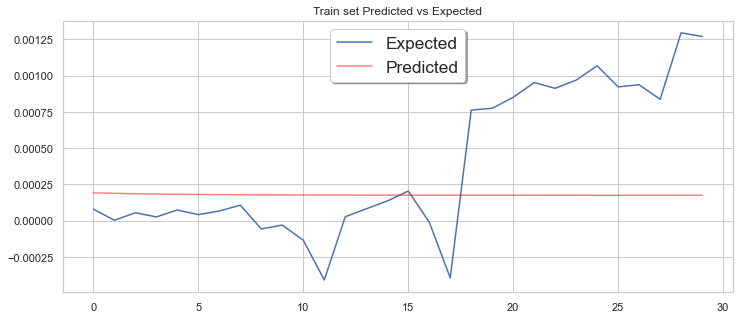

In [11]:
plt.plot(observations_test, label='Expected')
plt.plot(predictions_test, label='Predicted', color='red', alpha=0.5)
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title("Train set Predicted vs Expected")
plt.show()

As we can see, the out-of-box Exponential Smoothing model didn't work pretty much at all. We have a negative r-squared which means the model fits the data even worse than just a straight line. The Mean Absolute Percentage Error is also very high (28% against 2% of ARIMA(2,1,1))

In order to make this model work better, we will perform hyperparemeters tuning via GridSearch.

### Tuning Exponential Smoothing Model